<a href="https://colab.research.google.com/github/PrasadSalimath/Text-Analytics-on-Van-Gogh-Letters/blob/main/ECMM447_SNTA_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install required modules

!pip install requests_html
!pip install nltk
!pip install --upgrade gensim
!pip install pyldavis==3.2.1
!pip install pyLDAvis.gensim
!pip install pyyaml==5.4.1

     |████████████████████████████████| 83 kB 1.3 MB/s 
     |████████████████████████████████| 138 kB 35.9 MB/s 
     |████████████████████████████████| 112 kB 42.6 MB/s 
     |████████████████████████████████| 127 kB 47.0 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=6cc139c645d277a8027677554a73646b32669bf2b784cea8a7efa10629234fd5
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=7443d92bf65c279b63635f93cc8f0955fd127a177e428725305bfa10d980996d
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built fake-useragent parse
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not

In [2]:
import re
import pandas as pd
import string

# import requests
from requests_html import HTMLSession

# import nltk modules
import nltk
from nltk import PorterStemmer
from nltk import tokenize
from nltk.tokenize import wordpunct_tokenize
nltk.download('punkt')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

import spacy

# import gensim modules
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import networkx as nx

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# import modules for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.divide(0.4, 1, casting="unsafe", dtype=np.float),
/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults =

[nltk_data]   Unzipping corpora/omw-1.4.zip.


### Preparing the dataset for Vincent van Gogh Letters
There is no ready dataset available for Vincent van Gogh Letters and therefore as a part of this project, required dataset is extracted from the official website of Vincent van Gogh Letters (https://vangoghletters.org/vg/letters.html) using web scraping technique in Python. HTMLSession package is used to create an HTML session and connect to the website and extract required data by querying underlying HTML elements.

In [ ]:
# Web Scraping to extact data for Vincent van Gogh Letters

number_of_letter = 903
letter_urls =list()
url = "https://vangoghletters.org/vg/letters/let{}/letter.html"

letter_urls = [url.format(str(letter).zfill(3)) for letter in range(1, number_of_letter, 1)]

s = HTMLSession()

def get_van_gogh_letters_data(letter_urls):
    data_list = []

    for letter_url in letter_urls:
        resp = s.get(letter_url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36'})

        try:
            letter_text = resp.html.find('div#letterbox1', first=True).text
            letter_text = str.replace(resp.html.find('div#letterbox1', first=True).text, '\n', '').replace('1r:1','')

            letter_text = re.sub(".\d+",".", re.sub(",\d+", ",", letter_text))
            letter_no = resp.html.find('div#header h1', first=True).text
            
            header_text = re.split('To', resp.html.find('div#header h2', first=True).text, flags=re.IGNORECASE)
            from_text = 'Vincent van Gogh' if not header_text[0] else header_text[0]
            to_text = str.strip(str.split(header_text[1], '.')[0])
            date = str.strip(str.replace(str.split(resp.html.find('div#header h2', first=True).text, ',')[-1], '.', ''))
            day = str.strip(str.split(resp.html.find('div#header h2', first=True).text, ',')[-2])
            location_str = str.split(resp.html.find('div#note_location div.p', first=True).text, ',')[0:2]
            location = ','.join(location_str)
            
            data_list.append([letter_no, letter_text, from_text, to_text, day, date, location])
        except:
            print(letter_no)
    
    df_van_gogh = pd.DataFrame(data_list, columns=['letter_no', 'letter_text', 'from_text', 'to_text', 'day', 'date', 'location'])
    return df_van_gogh

In [ ]:
# get dataset for van gogh letters
df_van_gogh = get_van_gogh_letters_data(letter_urls)
# save the data to csv
df_van_gogh.to_csv('van_gogh_letters_data.csv', encoding='utf-8')

In [3]:
# load dataset for van gogh letters
df_van_gogh = pd.read_csv('van_gogh_letters_data.csv')
# drop unwanted columns
df_van_gogh = df_van_gogh.drop('Unnamed: 0', axis=1)

### Preprocessing the text data

In [4]:
def lemmatize_data(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
  """Lemmatize the text for allowed postags"""
  
  nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
  lemmatized_text = []
  for text in texts:
      doc = nlp(text)
      allowed_text = []
      for token in doc:
          if token.pos_ in allowed_postags:
              allowed_text.append(token.lemma_)
      lemmatized_text.append(" ".join(allowed_text))
  return (lemmatized_text)

def create_bigram_model(text):
  """Create bigram model for the text"""

  bigram = gensim.models.Phrases(text, min_count=5, threshold=50)
  bigrams_model = gensim.models.phrases.Phraser(bigram)
  
  return bigrams_model[text]
  
def create_trigram_model(text):
  """Create trigram model for the text"""

  bigram = gensim.models.Phrases(text, min_count=5, threshold=40)
  trigram = gensim.models.Phrases(bigram[text], threshold=40)

  bigrams_model = gensim.models.phrases.Phraser(bigram)
  trigrams_model = gensim.models.phrases.Phraser(trigram)

  text_bigrams = [bigrams_model[doc] for doc in text]
  return ([trigrams_model[bigrams_model[doc]] for doc in text])

def tokenize(text: str, stop_words, lemmatizer:WordNetLemmatizer):
  """Tokenize text data post cleaning"""
  text = text.lower() # lower the text
  text = re.sub("\d+","", text) # remove any numbers/digits in the text
  text = re.sub(r'[^\w\s]', '', text) # remove unwanted whitespaces
  tokens = wordpunct_tokenize(text)
  tokens = [token for token in tokens if token not in stop_words] # remove stopwords
  tokens = [token for token in tokens if token not in set(string.punctuation)]  # remove unwanted punctuations
  tokens = create_bigram_model(tokens)  # create bigram tokens
  tokens = lemmatize_data(tokens) # lemmatize the text
  tokens = [token for token in tokens if token] # include only the valid tokens (excluding any empty tokens)
  return tokens

# intialize the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# tokenize the text corpora
df_van_gogh['token_text'] = df_van_gogh.letter_text.apply(tokenize, args=(stop_words, wordnet_lemmatizer))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

## Topic Modeling
#### Topic modeling is an NLP technique to extract hidden topics or clusters from large text corpora that will provide insights into such corpora. 
#### Let's perform topic modeling using genism models.

In [6]:
def get_lda_model(corpus, id2word, num_topics=10, update_every=1, passes=1, alpha='auto', 
                  random_state=0, chunksize=50, per_word_topics=True, eval_every=None):
  """Create LDA model for the given model parameters"""
  return gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          num_topics=num_topics, 
                                          id2word=id2word,
                                          update_every=update_every, 
                                          passes=passes, 
                                          alpha=alpha,
                                          random_state=random_state,
                                          chunksize=chunksize,
                                          per_word_topics=per_word_topics, 
                                          eval_every=eval_every)

### **Topic Modeling: Iteration 1**
Let's try iteration 1 of topic modeling without N-gram and TFIDF removal *italicized text*

In [7]:
# with spacy lemmatization and without N-gram and TFIDF removal

term_dict = corpora.Dictionary(df_van_gogh.token_text)
document_term_frequency = [term_dict.doc2bow(text) for text in df_van_gogh.token_text]
document_term_frequency # for each document ->(index of the word, frequency of word)

lda_model = get_lda_model(corpus=document_term_frequency, 
                          num_topics=10, 
                          id2word=term_dict,
                          update_every=1, 
                          passes=10, 
                          alpha='auto',
                          random_state=0,
                          chunksize=100,
                          per_word_topics=True, 
                          eval_every=None)

lda_model.print_topics(num_topics=10, num_words=10)


[(0,
  '0.024*"much" + 0.023*"go" + 0.022*"little" + 0.021*"be" + 0.021*"would" + 0.021*"good" + 0.018*"send" + 0.016*"make" + 0.015*"come" + 0.015*"day"'),
 (1,
  '0.000*"timesyou" + 0.000*"idleregard" + 0.000*"werehaving" + 0.000*"conveniently" + 0.000*"dealwhy" + 0.000*"embark" + 0.000*"melancholically" + 0.000*"passively" + 0.000*"sheit" + 0.000*"tenancy"'),
 (2,
  '0.065*"exhibit" + 0.023*"sale" + 0.008*"upright" + 0.006*"vertical" + 0.005*"rail" + 0.005*"porter" + 0.004*"bathe" + 0.004*"canal" + 0.002*"cedar" + 0.002*"pavingstone"'),
 (3,
  '0.000*"timesyou" + 0.000*"idleregard" + 0.000*"werehaving" + 0.000*"conveniently" + 0.000*"dealwhy" + 0.000*"embark" + 0.000*"melancholically" + 0.000*"passively" + 0.000*"sheit" + 0.000*"tenancy"'),
 (4,
  '0.013*"awful" + 0.000*"christmasyour" + 0.000*"motherive" + 0.000*"hearten" + 0.000*"practicable" + 0.000*"sadden" + 0.000*"arlesbeside" + 0.000*"resurrect" + 0.000*"ronce" + 0.000*"logically"'),
 (5,
  '0.018*"love" + 0.016*"life" + 0.01

In [9]:
# lower perplexity and higher coherence = better the topic modeling
print('Perplexity:', lda_model.log_perplexity(document_term_frequency))

coherence_lda = CoherenceModel(model=lda_model, texts=df_van_gogh.token_text, dictionary=term_dict, coherence='c_v')
coherence = coherence_lda.get_coherence()
print('Coherence: ', coherence)

Perplexity: -7.4025708231744805
Coherence:  0.3666032737852464


## Visualizing the topic modelling
Results of topic modeling are not easy to interpret; therefore we would use pyLDAvis library to visualize the same.

In [13]:
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim.prepare(lda_model, document_term_frequency, term_dict, mds='mmds')
visualization

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.322319  0.047999       1        1  55.630018
6     -0.210217 -0.284778       2        1  18.776522
5     -0.186027  0.262336       3        1  12.866267
0     -0.385134 -0.119749       4        1  12.626796
2      0.176667 -0.012115       5        1   0.080621
4      0.187945  0.022438       6        1   0.010650
7      0.184771  0.020968       7        1   0.002306
8      0.184771  0.020968       8        1   0.002279
1      0.184771  0.020968       9        1   0.002278
3      0.184771  0.020968      10        1   0.002262, topic_info=        Term         Freq        Total Category  logprob  loglift
223   little  2444.000000  2444.000000  Default  30.0000  30.0000
54      much  2752.000000  2752.000000  Default  29.0000  29.0000
353   colour  1135.000000  1135.000000  Default  28.0000  28.0000
199    would  7022.000000  7022.000000  Default  27.0000  27.0000
71        be  4408.000000  4408.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
25     roose     0.000587    22.410557  Topic10  -9.3751   0.1461
26    safely     0.000587    27.450580  Topic10  -9.3751  -0.0568
27     spend     0.000587   246.215910  Topic10  -9.3751  -2.2506
28      stay     0.000587   600.959890  Topic10  -9.3751  -3.1429
29   strange     0.000587    96.615667  Topic10  -9.3751  -1.3151

[680 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.998544  actually
1166      1  0.349148       add
1166      2  0.650137       add
2149      2  0.994149    admire
1910      1  0.997235    affair
...     ...       ...       ...
134       2  0.081152       yet
134       3  0.261372       yet
134       4  0.025294       yet
717       1  0.031469     youth
717       3  0.975539     youth

[604 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 6, 1, 3, 5, 8, 9, 2, 4])

### **Topic Modeling: Iteration 2**
### Let's try finding the optimal number of topic models and also exclude the words with low score of TFIDF and see if it improves the quality of topics modeled.

In [12]:
# TFIDF words with low score removed

from gensim.models import TfidfModel

bigram_data = [create_bigram_model(doc) for doc in df_van_gogh.token_text]
id2word = corpora.Dictionary(bigram_data)
corpus = [id2word.doc2bow(text) for text in bigram_data]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


## Finding optimal number of Topic models
Perplexity measures the fit of a model in predicting probability distribution of text corpora.
Coherence measures the appearance of word in document as well as the topic within.
##### **A better model is the one with lower perplexity and higher coherence.**
Now, let's try finding the optimal number of topics (k) for LDA model so that we can get some sensible topics modeled.
##### We will use corpus with low score TFIDF words removed.

In [15]:
# finding the optimal number of topics for LDA model

perplexity = []
coherence = []
for k in range(2,20):
  lda_model = get_lda_model(corpus=corpus[:-1], 
                            num_topics=k, 
                            id2word=id2word,
                            update_every=1, 
                            passes=10, 
                            alpha='auto',
                            random_state=0,
                            chunksize=100,
                            per_word_topics=True, 
                            eval_every=None)
  perplexity.append(lda_model.log_perplexity(corpus))
  coherence_lda = CoherenceModel(lda_model, texts=df_van_gogh.token_text, dictionary=id2word, coherence='c_v')
  coherence.append(coherence_lda.get_coherence())

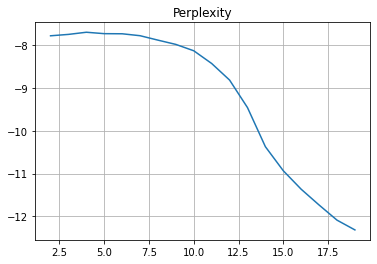

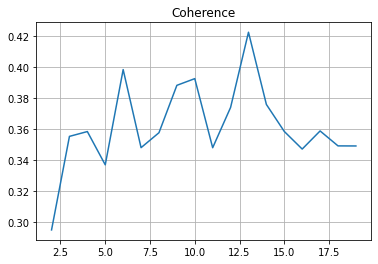

In [16]:
# plotting the perplexity and coherence
plt.grid()
plt.plot(range(2,20), perplexity, label='perplexity')
plt.title('Perplexity')
plt.show()
plt.grid()
plt.plot(range(2,20), coherence, label='coherence')
plt.title('Coherence')
plt.show()

In [25]:
# get LDA model for -> latest corpus + using bigram models + low score TFIDF words removed

# id2word of bigram corpus text
id2word = corpora.Dictionary(bigram_data)

lda_model = get_lda_model(corpus=corpus[:-1], 
                          num_topics=13, 
                          id2word=id2word,
                          update_every=1, 
                          passes=10, 
                          alpha='auto',
                          random_state=0,
                          chunksize=100,
                          per_word_topics=True, 
                          eval_every=None)

lda_model.print_topics(num_topics=13, num_words=10)

# visualize the modelled topics
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
visualization

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.219547  0.130098       1        1  45.057999
11     0.253637  0.230615       2        1  25.290738
10     0.291310 -0.204974       3        1  11.794026
2      0.020288  0.165541       4        1   6.119022
3      0.028205  0.040147       5        1   5.135451
8     -0.012455  0.122538       6        1   3.679151
0      0.264036 -0.263953       7        1   1.686987
9     -0.183108 -0.059024       8        1   0.537915
4     -0.183586 -0.052803       9        1   0.534004
7     -0.176232 -0.029812      10        1   0.094138
6     -0.174804 -0.027126      11        1   0.043948
12    -0.173805 -0.026046      12        1   0.022033
1     -0.173032 -0.025200      13        1   0.004590, topic_info=          Term         Freq        Total Category  logprob  loglift
199      would  2088.000000  2088.000000  Default  30.0000  30.0000
185        say  1795.000000  1795.000000  Default  29.0000  29.0000
104   painting  1324.000000  1324.000000  Default  28.0000  28.0000
126      think  1086.000000  1086.000000  Default  27.0000  27.0000
1142     study   841.000000   841.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
25       roose     0.000769    17.694709  Topic13  -9.3751  -0.0545
26      safely     0.000769    24.575077  Topic13  -9.3751  -0.3830
27       spend     0.000769   247.250901  Topic13  -9.3751  -2.6917
28        stay     0.000769   500.243664  Topic13  -9.3751  -3.3964
29     strange     0.000769   111.648298  Topic13  -9.3751  -1.8966

[697 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
201       2  0.928313        able
201       3  0.071032        able
922       2  0.998515  absolutely
1680      7  0.185523      action
1680      8  0.742092      action
...     ...       ...         ...
133       5  0.027069        year
134       1  0.988241         yet
134       2  0.004523         yet
134       3  0.006784         yet
1524      9  0.774278    youthere

[690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 12, 11, 3, 4, 9, 1, 10, 5, 8, 7, 13, 2])

In [26]:
lda_model.print_topics(num_topics=13, num_words=10)

[(0,
  '0.087*"much" + 0.058*"child" + 0.042*"may" + 0.029*"rest" + 0.027*"leave" + 0.026*"afraid" + 0.026*"lot" + 0.024*"speak" + 0.020*"back" + 0.017*"gachet"'),
 (1,
  '0.000*"timesyou" + 0.000*"idleregard" + 0.000*"werehaving" + 0.000*"conveniently" + 0.000*"dealwhy" + 0.000*"embark" + 0.000*"melancholically" + 0.000*"passively" + 0.000*"sheit" + 0.000*"tenancy"'),
 (2,
  '0.033*"tree" + 0.029*"sky" + 0.025*"effect" + 0.021*"arle" + 0.019*"see" + 0.017*"garden" + 0.017*"evening" + 0.014*"dark" + 0.014*"flower" + 0.014*"field"'),
 (3,
  '0.206*"would" + 0.176*"say" + 0.107*"think" + 0.086*"want" + 0.019*"people" + 0.016*"way" + 0.014*"question" + 0.011*"money" + 0.011*"reason" + 0.011*"part"'),
 (4,
  '0.239*"consider" + 0.079*"consignment" + 0.043*"reality" + 0.040*"expensive" + 0.024*"existence" + 0.014*"box" + 0.011*"ensure" + 0.009*"reasonably" + 0.005*"vit" + 0.005*"previous"'),
 (5,
  '0.031*"little" + 0.013*"feel" + 0.008*"life" + 0.007*"love" + 0.007*"woman" + 0.007*"subject

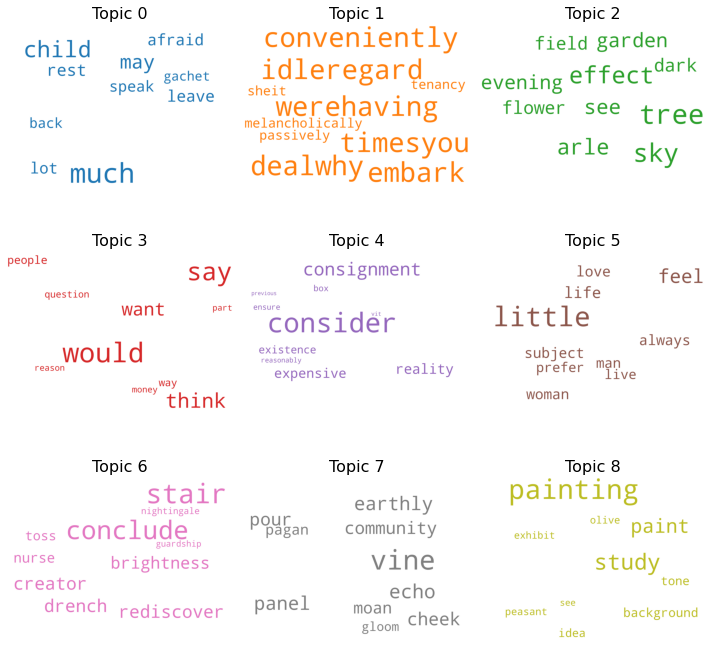

In [28]:
# plotting topics modeled for easy interpretation
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def plot_topic_models(topics, colors):
  cloud = WordCloud(stopwords=stop_words,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: colors[i],
                    prefer_horizontal=1.0)

  fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()

topics = lda_model.show_topics(num_topics=13, num_words=10, formatted=False)
colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
plot_topic_models(topics, colors)

## Network Analysis of Van Gogh Letters dataset
Let’s carry out the network analysis of the letters data to get better understanding flow of letters sent and received.

In [30]:
# clean letter_to text data 
def removeUnwantedWords(text):
    text = re.sub('\d+', '', text)
    wordsToRemove = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december' ]
    re_remove_words = re.compile(r"\b(" + "|".join(wordsToRemove) + ")\\W", re.I | re.IGNORECASE)
    return re_remove_words.sub("", text)

df_van_gogh.to_text = df_van_gogh.to_text.apply(removeUnwantedWords)

<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-30-ec36308a2f7e>:3: DeprecationWarning: invalid escape sequence \d
  text = re.sub('\d+', '', text)


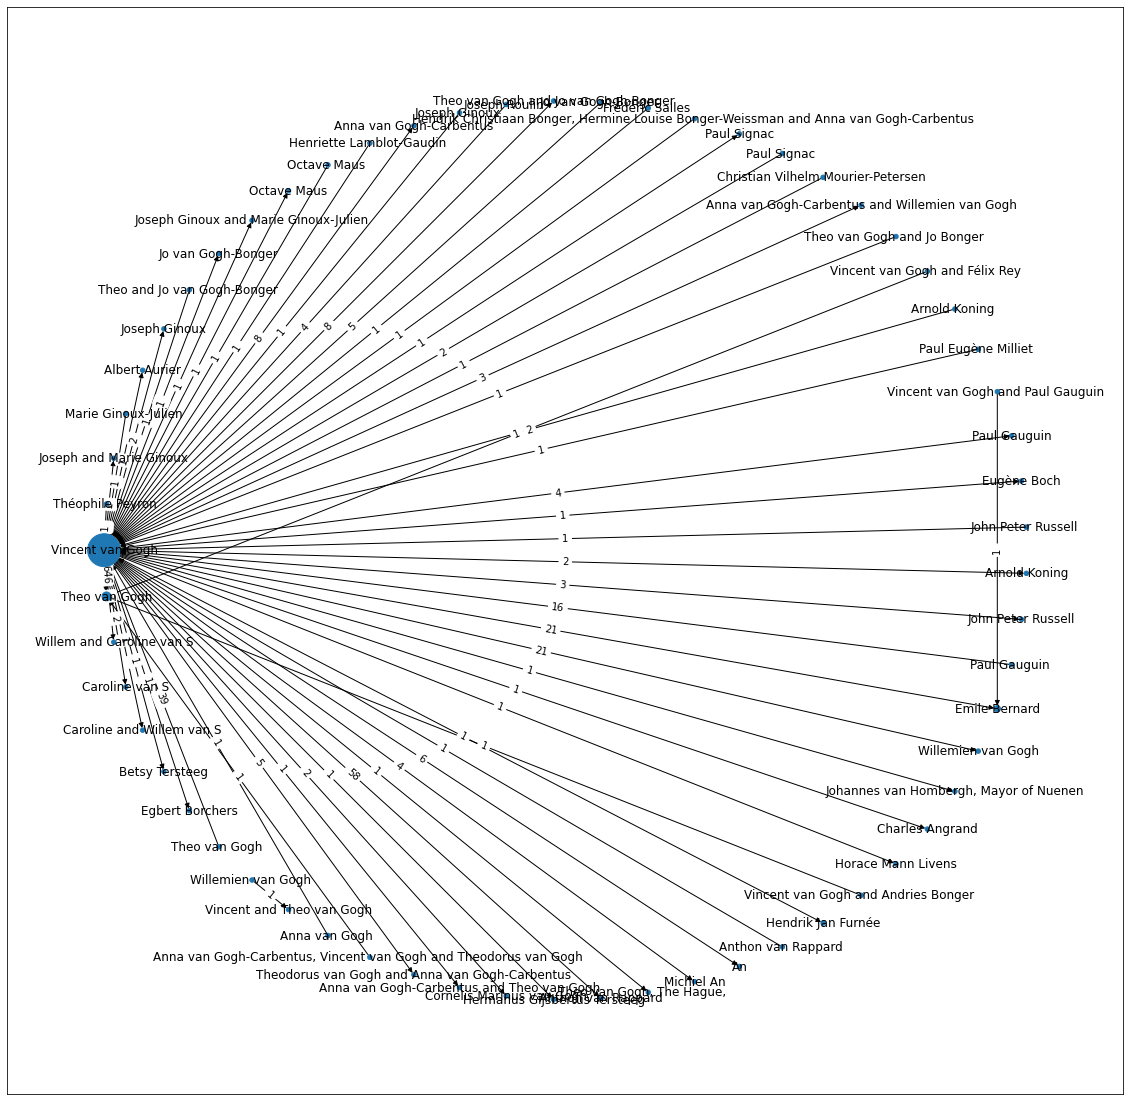

In [31]:
# network of letters by van gogh based on degree of nodes
from collections import Counter

def draw_network_of_letters(G, data):  
  for from_to, cnt in data.items():
    G.add_edge(from_to[0], from_to[1], weight=cnt)

  pos = nx.shell_layout(G)
  labels = nx.get_edge_attributes(G, 'weight')
  plt.figure(3, figsize=(20,20))

  nx.draw_networkx(G, pos, node_size=[n*20 for n in dict(G.degree()).values()])
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

G = nx.DiGraph()
# create data for graph
from_to_data = Counter(zip(df_van_gogh.from_text, df_van_gogh.to_text))
# draw network of letters
draw_network_of_letters(G, from_to_data)

In [ ]:
# Frequency of letter sent and received by Van Gogh

from collections import Counter
from_to_data = Counter(zip(df_van_gogh.from_text, df_van_gogh.to_text))

from_to_data.most_common()

[(('Vincent van Gogh', 'Theo van Gogh'), 646),
 (('Vincent van Gogh', 'Anthon van Rappard'), 58),
 (('Theo van Gogh ', 'Vincent van Gogh'), 39),
 (('Vincent van Gogh', 'Willemien van Gogh'), 21),
 (('Vincent van Gogh', 'Emile Bernard'), 21),
 (('Paul Gauguin ', 'Vincent van Gogh'), 16),
 (('Vincent van Gogh', 'Theo van Gogh and Jo van Gogh-Bonger'), 8),
 (('Vincent van Gogh', 'Anna van Gogh-Carbentus'), 8),
 (('Vincent van Gogh', 'An'), 6),
 (('Vincent van Gogh', 'Theodorus van Gogh and Anna van Gogh-Carbentus'), 5),
 (('Jo van Gogh-Bonger ', 'Vincent van Gogh'), 5),
 (('Vincent van Gogh', 'Michiel An'), 4),
 (('Vincent van Gogh', 'Paul Gauguin'), 4),
 (('Joseph Roulin ', 'Vincent van Gogh'), 4),
 (('Vincent van Gogh', 'Willem and Caroline van S'), 3),
 (('Vincent van Gogh', 'John Peter Russell'), 3),
 (('Vincent van Gogh', 'Anna van Gogh-Carbentus and Willemien van Gogh'), 3),
 (('Vincent van Gogh', 'Caroline van S'), 2),
 (('Vincent van Gogh', 'Cornelis Marinus van Gogh'), 2),
 (('Vi

## Sentiment Analysis
#### Let's perform sentiment analysis on van Gogh letters data using flair models

In [32]:
!pip install flair
from flair.models import TextClassifier
from flair.data import Sentence

     |████████████████████████████████| 401 kB 5.3 MB/s 
     |████████████████████████████████| 981 kB 48.0 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 4.0 MB 38.8 MB/s 
     |████████████████████████████████| 1.2 MB 35.7 MB/s 
     |████████████████████████████████| 788 kB 35.0 MB/s 
     |████████████████████████████████| 1.6 MB 34.3 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 199 kB 47.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.6 MB 32.1 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
  Created wheel

In [33]:
def sentiment_analysis(text):
  '''Perform sentiment analysis of input text data'''
  sentence = Sentence(text['letter_text'])
  text_classifier.predict(sentence)

  acc_re = re.search('\(0(.*)\)', str(sentence.labels))
  acc = acc_re.group(1) if acc_re is not None else 0
  acc = float(acc)
  polarity = ''
  if acc >= 0.9:
    polarity = 'Positive'
  elif acc <= 0.5:
    polarity = 'Neutral'
  else:
    polarity = 'Negative'
  return polarity, acc

text_classifier = TextClassifier.load('en-sentiment')
df_van_gogh[['polarity', 'acc']] = df_van_gogh.apply(lambda x:sentiment_analysis(x), axis=1, result_type='expand')
df_van_gogh

<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<input>:5: DeprecationWarning: invalid escape sequence \(
<ipython-input-33-aff59fcd63e1>:5: DeprecationWarning: invalid escape sequence \(
  acc_re = re.search('\(0(.*)\)', str(sentence.labels))


2022-04-25 22:26:11,706 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpi8r_3vt3


100%|██████████| 265512723/265512723 [00:15<00:00, 17055041.13B/s]

2022-04-25 22:26:27,701 copying /tmp/tmpi8r_3vt3 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-04-25 22:26:28,514 removing temp file /tmp/tmpi8r_3vt3
2022-04-25 22:26:28,555 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

,letter_no,letter_text,from_text,to_text,day,date,location,token_text,polarity,acc
0,1,"The Hague, 29 September 1872.My dear Theo,Than...",Vincent van Gogh,Theo van Gogh,Sunday,29 September 1872,"Amsterdam, Van Gogh Museum","[dear, letter, hear, get, back, safely, miss, ...",Negative,0.8072
1,2,"The Hague, 13 December 1872.My dear Theo,That ...",Vincent van Gogh,Theo van Gogh,Friday,13 December 1872,"Amsterdam, Van Gogh Museum","[dear, good, news, read, letter, doubt, give, ...",Positive,0.9991
2,3,"The Hague, January 1873My dear Theo,I heard fr...",Vincent van Gogh,Theo van Gogh,NaN,mid-January 1873,"Amsterdam, Van Gogh Museum","[dear, hear, home, arrive, safe, first, impres...",Positive,0.9960
3,4,"The Hague, 28 Jan. 1873My dear Theo,It’s good ...",Vincent van Gogh,Theo van Gogh,Tuesday,28 January 1873,"Amsterdam, Van Gogh Museum","[dear, theoit, good, answer, quickly, be, thin...",Positive,0.9528
4,5,"The Hague, 17 March 1873My dear Theo,It’s time...",Vincent van Gogh,Theo van Gogh,Monday,17 March 1873,"Amsterdam, Van Gogh Museum","[dear, theoit, time, hear, be, also, hear, wil...",Positive,0.9626
...,...,...,...,...,...,...,...,...,...,...
897,898,"Dear brother and sister,Jo’s letter was really...",Vincent van Gogh,Theo van Gogh and Jo van Gogh-Bonger,Thursday,10 July 1890,"Amsterdam, Van Gogh Museum","[dear, brother, letter, really, deliverance, c...",Negative,0.5831
898,899,"Dear mother and sister,Sincere thanks for your...",Vincent van Gogh,Anna van Gogh-Carbentus and Willemien van Gogh,Monday,14 July 1890,"Amsterdam, Van Gogh Museum","[dear, mother, sistersincere, thank, letter, g...",Positive,0.9999
899,900,"14 July 1890My dear Vincent,We’re very pleased...",Theo van Gogh,Vincent van Gogh,Monday,14 July 1890,"Amsterdam, Van Gogh Museum","[dear, be, longer, much, impression, matter, u...",Positive,0.9109
900,901,"22 July 1890My dear Vincent,From Holland Jo se...",Theo van Gogh,Vincent van Gogh,Tuesday,22 July 1890,"Amsterdam, Van Gogh Museum","[dear, send, letter, follow, read, violent, do...",Positive,0.9690


In [40]:
# proportion of letters with positive and negative polarity
def extract_letter_dates(date_text):
    date_re = re.search('[0-9]{4}', date_text)
    return int(date_re.group(0)) if date_re is not None else date_text

df_van_gogh['year'] = df_van_gogh.date.apply(extract_letter_dates)

df_painting = df_van_gogh.query("year >= 1880")
df_painting.polarity.value_counts()

df_van_gogh.polarity.value_counts()

Positive    655
Negative    221
Neutral      26
Name: polarity, dtype: int64

In [ ]:
# !pip install pyyaml==5.4.1
# import plotly.express as px
plt.figure(figsize=(10,10))
px.scatter(df_van_gogh, x=df_van_gogh.acc, y=df_van_gogh.year, width=800, height=600, symbol=df_van_gogh.polarity, color=df_van_gogh.polarity, title='Sentiment Analysis of Van Gogh Letters', labels=('sdfsd','sdf'))

<Figure size 720x720 with 0 Axes>